In [70]:
MODELS_FROM_FILE = 1
IMPORTANCES_FROM_FILE = 0

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import ElasticNet

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_auc_score, fbeta_score, make_scorer, roc_curve, precision_recall_curve, accuracy_score, r2_score
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

    
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', None)


data_intermediate_dir = "data/intermediate/"
item_lvl_w_imp = pd.read_csv(data_intermediate_dir + "item_lvl_wo_impairment.csv")

# Prepare input and ouptut column names

output_cols = [x for x in item_lvl_w_imp.columns if x.startswith("WHODAS") or x.startswith("CIS")] # All impairment columns

input_cols = [x for x in item_lvl_w_imp.columns if 
                       not x.startswith("Diag: ") 
                       and not x.startswith("WIAT")
                       and not x.startswith("WISC")
                       and not x.startswith("WHODAS")
                       and not x.startswith("CIS")] # Input columns are all columns except Diagnosis, WIAT, and WISC, impairment columns

# Separate test set for all impairment scores

# Shuffle the dataset 
shuffle_df = item_lvl_w_imp.sample(frac=1, random_state=42)

# Define a size for the train set 
train_size = int(0.7 * len(item_lvl_w_imp))

# Split the dataset 
train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:] # Don't touch this until the end

# Train_train and Validation set
# Define a size for your train_train set 
train_train_size = int(0.7 * len(train_set))

# Split your dataset 
train_train_set = train_set[:train_train_size]
val_set = train_set[train_train_size:]

In [37]:
def get_base_models_and_param_grids():
    
    # Define base models
    dt = DecisionTreeRegressor()
    rf = RandomForestRegressor()
    svr = svm.SVR()
    en = ElasticNet()
    
    # Impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    # Standardize data
    scaler = StandardScaler()

    # Make pipelines
    dt_pipe = make_pipeline(imputer, scaler, dt)
    rf_pipe = make_pipeline(imputer, scaler, rf)
    svr_pipe = make_pipeline(imputer, scaler, svr)
    en_pipe = make_pipeline(imputer, scaler, en)
    
    # Define parameter grids to search for each pipe
    from scipy.stats import loguniform, uniform
    dt_param_grid = {
        "decisiontreeregressor__splitter": ["best","random"],
        "decisiontreeregressor__min_samples_split": np.random.randint(2, 20, 30),
        "decisiontreeregressor__max_depth": np.random.randint(1, 30, 30),
        "decisiontreeregressor__min_samples_leaf": np.random.randint(1, 20, 30),
        "decisiontreeregressor__max_leaf_nodes": np.random.randint(2, 50, 30)
    }
    rf_param_grid = {
        'randomforestregressor__max_depth' : np.random.randint(5, 150, 30),
        'randomforestregressor__min_samples_split': np.random.randint(2, 50, 30),
        'randomforestregressor__n_estimators': np.random.randint(50, 400, 10),
        'randomforestregressor__min_samples_leaf': np.random.randint(1, 20, 30),
        'randomforestregressor__max_features': ['auto', 'sqrt', 'log2', 0.25, 0.5, 0.75, 1.0]
    }
    svr_param_grid = {
        'svr__C': loguniform(1e-03, 1e+02),
        'svr__gamma': loguniform(1e-03, 1e+02),
        'svr__degree': uniform(2, 5),
        'svr__epsilon': loguniform(1e-03,1),
        'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
    en_param_grid = {
        'elasticnet__alpha': loguniform(1e-5, 100),
        'elasticnet__l1_ratio': uniform(0, 1)
    }
    
    base_models_and_param_grids = [
        (dt_pipe, dt_param_grid),
        (rf_pipe, rf_param_grid),
        (svr_pipe, svr_param_grid),
        (en_pipe, en_param_grid),
    ]
    
    return base_models_and_param_grids

def get_best_classifier(base_model, grid, output_col):
    rs = RandomizedSearchCV(estimator=base_model, param_distributions=grid, cv=3, scoring="r2", n_iter=100, n_jobs = -1)
    
    rs.fit(train_set[input_cols], train_set[output_col]) # On train_set, not train_train_set because do cross-validation
    
    best_estimator = rs.best_estimator_
    best_score = rs.best_score_
    
    # If chosen model is SVM add a predict_proba parameter (not needed for grid search, and slows it down significantly)
    if 'svc' in best_estimator.named_steps.keys():
        best_estimator.set_params(svc__probability=True)

    return (best_estimator, best_score)

In [38]:
def find_best_estimator_for_output(output_col):
    best_score = 0
    best_classifier = None
    base_models_and_param_grids = get_base_models_and_param_grids()
    for (base_model, grid) in base_models_and_param_grids:
        best_classifier_for_model, best_score_for_model = get_best_classifier(base_model, grid, output_col)
        if best_score_for_model > best_score:
            best_classifier = best_classifier_for_model
            best_score = best_score_for_model
    return best_classifier

In [39]:
if MODELS_FROM_FILE == 0:
    best_estimators = {}
    for output in output_cols:
        best_estimator_for_output = find_best_estimator_for_output(output)
        best_estimators[output] = best_estimator_for_output
        print("Best estimator for ", output, ": ", best_estimators[output])

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.658e+03, tolerance: 1.736e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.010e+03, tolerance: 1.746e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.902e+03, tolerance: 1.746e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.112e+03, tolerance: 1.723e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.080e+03, tolerance: 1.723e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.671e+03, tolerance: 1.736e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.056e+03, tolerance: 1.723e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.664e+03, tolerance: 1.736e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.189e+03, tolerance: 1.723e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.658e+03, tolerance: 1.736e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.576e+03, tolerance: 1.736e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.895e+03, tolerance: 1.746e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Best estimator for  WHODAS_P,WHODAS_P_Total :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.6743960770835252,
                            l1_ratio=0.8245428573043805))])


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.459e+02, tolerance: 6.304e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.804e+02, tolerance: 6.332e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.550e+02, tolerance: 6.555e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.474e+02, tolerance: 6.304e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.545e+02, tolerance: 6.304e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.254e+02, tolerance: 6.555e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.283e+02, tolerance: 6.555e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.605e+02, tolerance: 6.332e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.312e+02, tolerance: 6.332e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.233e+02, tolerance: 6.304e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.383e+02, tolerance: 6.332e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.245e+02, tolerance: 6.304e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Best estimator for  CIS_P,CIS_P_Score :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.38138641155692465,
                            l1_ratio=0.43507165430090455))])


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.449e+03, tolerance: 2.097e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.090e+03, tolerance: 2.141e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.692e+03, tolerance: 2.141e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.651e+03, tolerance: 2.208e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.839e+03, tolerance: 2.097e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.771e+03, tolerance: 2.141e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.716e+03, tolerance: 2.208e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.907e+03, tolerance: 2.097e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.931e+03, tolerance: 2.097e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.005e+04, tolerance: 2.141e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Best estimator for  WHODAS_SR,WHODAS_SR_Score :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.8518914134075185,
                            l1_ratio=0.9552165736351792))])


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.189e+03, tolerance: 5.983e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.571e+03, tolerance: 6.116e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.605e+03, tolerance: 6.116e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.924e+03, tolerance: 5.983e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.182e+03, tolerance: 5.983e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.561e+03, tolerance: 6.116e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.069e+02, tolerance: 5.983e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.036e+03, tolerance: 6.116e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.941e+02, tolerance: 6.692e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.168e+03, tolerance: 5.983e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Best estimator for  CIS_SR,CIS_SR_Total :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.5657098026073939,
                            l1_ratio=0.7009067835681673))])


In [45]:
from joblib import dump, load
if MODELS_FROM_FILE == 0:
    # Save best estimators - best parameters, and the estimator objects themselves
    best_estimators_df = pd.DataFrame([best_estimators]).T.reset_index()
    best_estimators_df.columns = ["Output", "Best Estimator"]
    display(best_estimators_df)
    best_estimators_df.to_csv("data/output/best-estimators-imp-item-lvl.csv")

    dump(best_estimators, 'best-estimators-imp-item-lvl.joblib', compress=1)

,Output,Best Estimator
0,"WHODAS_P,WHODAS_P_Total","(SimpleImputer(strategy='median'), StandardScaler(), ElasticNet(alpha=0.6743960770835252, l1_ratio=0.8245428573043805))"
1,"CIS_P,CIS_P_Score","(SimpleImputer(strategy='median'), StandardScaler(), ElasticNet(alpha=0.38138641155692465, l1_ratio=0.43507165430090455))"
2,"WHODAS_SR,WHODAS_SR_Score","(SimpleImputer(strategy='median'), StandardScaler(), ElasticNet(alpha=0.8518914134075185, l1_ratio=0.9552165736351792))"
3,"CIS_SR,CIS_SR_Total","(SimpleImputer(strategy='median'), StandardScaler(), ElasticNet(alpha=0.5657098026073939, l1_ratio=0.7009067835681673))"


In [46]:
if MODELS_FROM_FILE == 1:
    best_estimators = load('best-estimators-imp-item-lvl.joblib')

In [73]:
metric_names = ['r2']   
def get_metrics(estimator, output_col, input_cols, validation_or_test = "validation", print_output_flag = 0):
    input_cols = input_cols
    
    if validation_or_test == "test":
        x = test_set[input_cols]
        y = test_set[output_col]
    else: 
        x = val_set[input_cols]
        y = val_set[output_col]
        
    y_pred = estimator.predict(x)
    
    metrics = []
    r2 = r2_score(y, y_pred)
    metrics.append(r2)
    
    if print_output_flag:
        print(output_col)
        print("r2: ", r2)
        
        plt.scatter(y, y_pred)
        plt.show()
        
    return metrics

,test_score,train_score
0,0.463905,0.604224
1,0.516788,0.591043
2,0.489253,0.588543
3,0.497255,0.590261
4,0.511279,0.582798


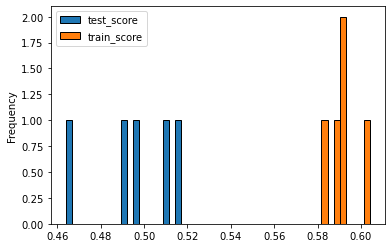

,test_score,train_score
0,0.734595,0.793699
1,0.686602,0.795858
2,0.741679,0.789810
3,0.715547,0.786168
4,0.738599,0.792814


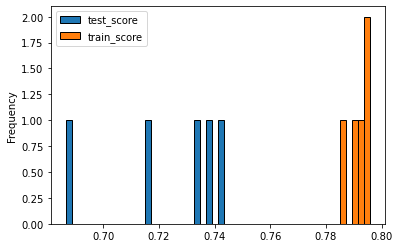

,test_score,train_score
0,0.128316,0.165942
1,0.058516,0.179252
2,0.060832,0.177157
3,0.101193,0.171516
4,0.052682,0.186277


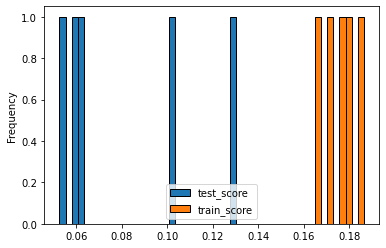

,test_score,train_score
0,0.202141,0.268781
1,0.169612,0.283628
2,0.202697,0.276903
3,0.235895,0.267012
4,0.122656,0.292219


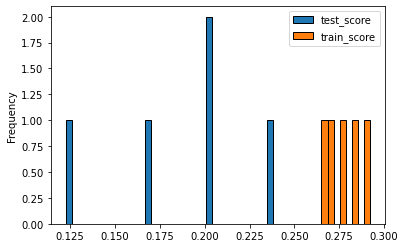

,Output,Mean R2,Std R2
0,"WHODAS_P,WHODAS_P_Total",0.495696,0.018667
1,"CIS_P,CIS_P_Score",0.723404,0.020524
2,"WHODAS_SR,WHODAS_SR_Score",0.080308,0.029524
3,"CIS_SR,CIS_SR_Total",0.186600,0.038231


In [66]:
# Check cross-validation performance of the final model on validation set for all models
def plot_test_vs_train_scores(cv_results):
    scores = pd.DataFrame(cv_results)[["test_score", "train_score"]]
    display(scores)
    scores.plot.hist(bins=50, edgecolor="black")
    plt.show()

results_val_set = []
for output in output_cols:
    estimator = best_estimators[output]
    cv_results = cross_validate(estimator, train_set[input_cols], train_set[output], return_train_score = True)
    metrics = [np.mean(cv_results["test_score"]), np.std(cv_results["test_score"])]
    results_val_set.append([
        output, 
        *metrics])
    
    plot_test_vs_train_scores(cv_results)
restults_val_set_df = pd.DataFrame(results_val_set, columns=["Output"] + ["Mean R2", "Std R2"])
restults_val_set_df

WHODAS_P,WHODAS_P_Total
r2:  0.4475017258552777


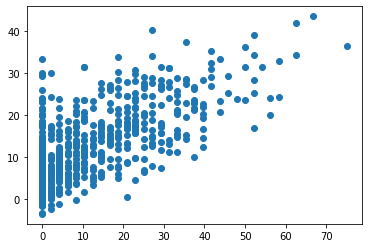

CIS_P,CIS_P_Score
r2:  0.732103177547599


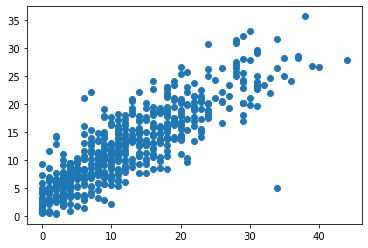

WHODAS_SR,WHODAS_SR_Score
r2:  0.08018548518139046


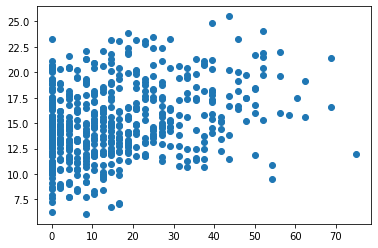

CIS_SR,CIS_SR_Total
r2:  0.18071396491318936


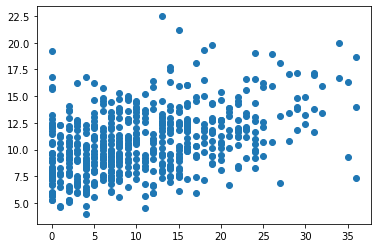

,Output,r2
1,"CIS_P,CIS_P_Score",0.732103
0,"WHODAS_P,WHODAS_P_Total",0.447502
3,"CIS_SR,CIS_SR_Total",0.180714
2,"WHODAS_SR,WHODAS_SR_Score",0.080185


In [74]:
# Check performance of the final model on test set for all models

results_test_set = []
for output in output_cols:
    estimator = best_estimators[output]
    metrics = get_metrics(estimator, output, input_cols, 'test', 1)
    results_test_set.append([
        output, 
        *metrics])
restults_test_set_df = pd.DataFrame(results_test_set, columns=["Output"] + metric_names)
restults_test_set_df.sort_values(by="r2", ascending=False)

In [ ]:
### Feature importance

In [75]:
if IMPORTANCES_FROM_FILE == 1:
    forward_feature_objects = {}
    backward_feature_objects = {}
    try:
        forward_feature_objects = load('forward-sfs-imp-item-lvl.joblib')
    except Exception as e: print(e)

In [76]:
# Find elbow of the curve (draw a line from the first to the last point of the curve and then find the data point that is farthest away from that line) https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve 
def find_elbow(curve):
    from numpy import matlib 
    n_points = len(curve)
    all_coord = np.vstack((range(n_points), curve)).T
    first_point = all_coord[0]
    line_vec = all_coord[-1] - all_coord[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coord - first_point
    scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    idx_of_best_point = np.argmax(dist_to_line)
    return idx_of_best_point + 1

def analyze_importances(importances):
    importances_list = []
    for key in importances:
        importances_list.append(importances[key]['avg_score'])
    importances_df = pd.DataFrame(importances_list, index=importances.keys(), columns=["r2"])
    display(importances_df)

    max_score = max(importances_list)
    n_cols_max_score = importances_df[importances_df["r2"] == max_score].index[0]
    print("Max score: ", max_score, " at ", n_cols_max_score, " features")
    features_up_to_max_score = importances[n_cols_max_score]["feature_names"]

    plt.figure(figsize=(16,8))
    plt.plot(importances_df)
    plt.xticks(np.arange(1,100, 3))
    plt.vlines(np.arange(1,100, 3), ymin=min(importances_list), ymax=max(importances_list), colors='purple', ls=':', lw=1)
    plt.show()
    
    optimal_nb_features = find_elbow(importances_list)
    print("Optimal number of features: ", optimal_nb_features)
    
    features_up_to_optimal = importances[optimal_nb_features]["feature_names"]
    display(features_up_to_optimal)
    
    return (features_up_to_optimal, features_up_to_max_score)

WHODAS_P,WHODAS_P_Total


,r2
1,0.206761
2,0.306564
3,0.365513
4,0.411104
5,0.439418
...,...
96,0.544095
97,0.544095
98,0.544095
99,0.544095


Max score:  0.5440951787288743  at  77  features


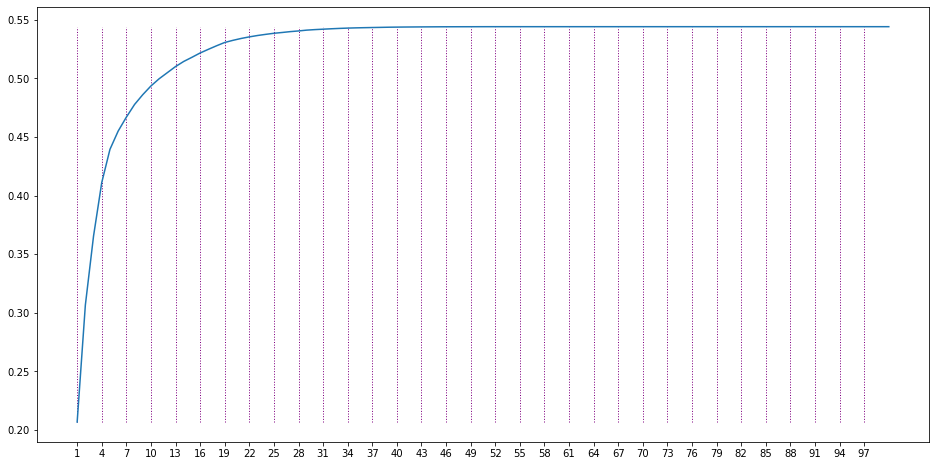

Optimal number of features:  16


('SympChck,CSC_12C',
 'ASSQ,ASSQ_18',
 'ASSQ,ASSQ_24',
 'SDQ,SDQ_26',
 'SDQ,SDQ_29_b',
 'SWAN,SWAN_02',
 'SRS,SRS_20',
 'SRS,SRS_34',
 'SRS,SRS_36',
 'CBCL,CBCL_24',
 'CBCL,CBCL_62',
 'ESWAN,SocAnx_05',
 'MFQ_P,MFQ_P_06',
 'MFQ_P,MFQ_P_21',
 'PSI,PSI_21',
 'RBS,RBS_23')

CIS_P,CIS_P_Score


,r2
1,0.374405
2,0.496001
3,0.550469
4,0.582300
5,0.612462
...,...
96,0.754467
97,0.754477
98,0.754485
99,0.754493


Max score:  0.7544979637157226  at  100  features


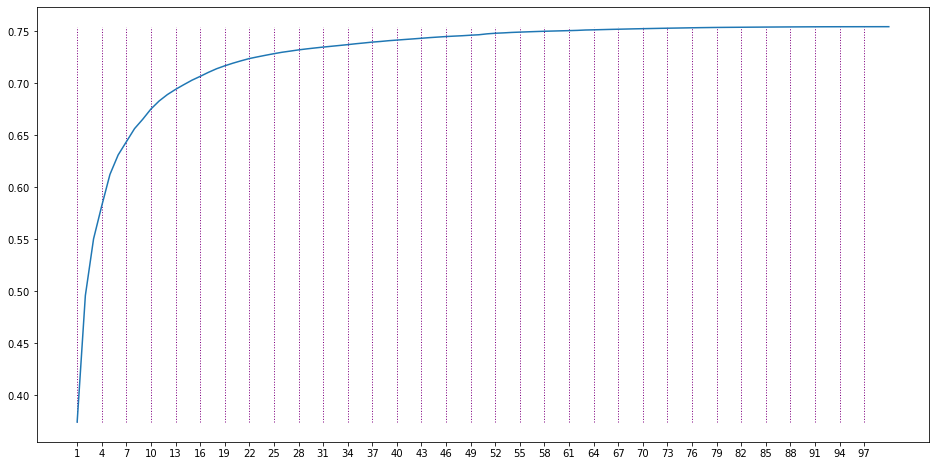

Optimal number of features:  15


('ASSQ,ASSQ_18',
 'ARI_P,ARI_P_02',
 'ARI_P,ARI_P_07',
 'SDQ,SDQ_07',
 'SDQ,SDQ_12',
 'SDQ,SDQ_26',
 'SDQ,SDQ_29_a',
 'SRS,SRS_64',
 'CBCL,CBCL_103',
 'CBCL,CBCL_25',
 'CBCL,CBCL_28',
 'CBCL,CBCL_61',
 'PCIAT,PCIAT_18',
 'MFQ_P,MFQ_P_29',
 'PSI,PSI_35')

WHODAS_SR,WHODAS_SR_Score


,r2
1,0.025494
2,0.040086
3,0.051475
4,0.061662
5,0.071333
...,...
96,0.121176
97,0.121176
98,0.121176
99,0.121176


Max score:  0.1211760983622822  at  62  features


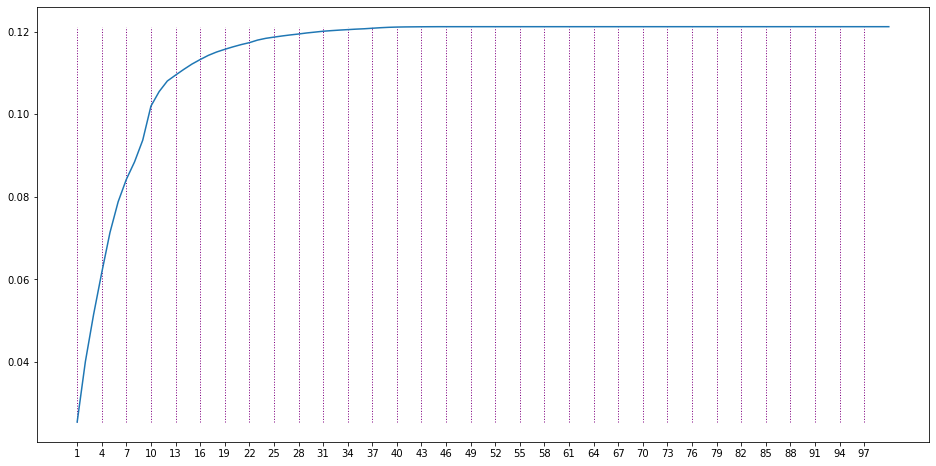

Optimal number of features:  17


('Basic_Demos,Age',
 'SympChck,CSC_43C',
 'SCQ,SCQ_32',
 'SDQ,SDQ_03',
 'SDQ,SDQ_23',
 'SRS,SRS_14',
 'SRS,SRS_19',
 'SRS,SRS_36',
 'CBCL,CBCL_12',
 'CBCL,CBCL_52',
 'APQ_P,APQ_P_42',
 'APQ_SR,APQ_SR_06',
 'APQ_SR,APQ_SR_07A',
 'APQ_SR,APQ_SR_24',
 'APQ_SR,APQ_SR_31',
 'APQ_SR,APQ_SR_39',
 'APQ_SR,APQ_SR_42')

CIS_SR,CIS_SR_Total


,r2
1,0.077165
2,0.105085
3,0.133302
4,0.150409
5,0.164161
...,...
96,0.222413
97,0.222413
98,0.222413
99,0.222413


Max score:  0.2224126737182743  at  99  features


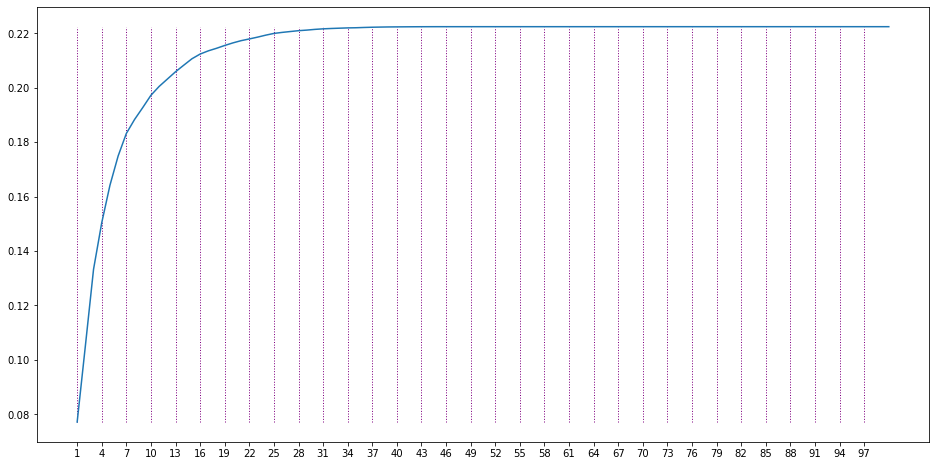

Optimal number of features:  16


('SDQ,SDQ_07',
 'SDQ,SDQ_13',
 'SWAN,SWAN_10',
 'SRS,SRS_19',
 'APQ_P,APQ_P_42',
 'MFQ_P,MFQ_P_15',
 'APQ_SR,APQ_SR_01',
 'APQ_SR,APQ_SR_02',
 'APQ_SR,APQ_SR_07A',
 'APQ_SR,APQ_SR_12',
 'APQ_SR,APQ_SR_31',
 'APQ_SR,APQ_SR_33',
 'APQ_SR,APQ_SR_35',
 'APQ_SR,APQ_SR_36',
 'APQ_SR,APQ_SR_39',
 'APQ_SR,APQ_SR_42')

In [79]:
from mlxtend.feature_selection import SequentialFeatureSelector

if IMPORTANCES_FROM_FILE == 0:
    forward_feature_subsets = {}
    forward_feature_objects = {}
    for output in output_cols:
        print(output)
        estimator = best_estimators[output]

        sfs = SequentialFeatureSelector(estimator, 
              k_features=100,
              forward=True, 
              scoring='r2',
              cv=3,
              n_jobs=-1)

        sfs = sfs.fit(train_set[input_cols], train_set[output])

        forward_feature_subsets[output] = sfs.subsets_
        forward_feature_objects[output] = sfs
        
        analyze_importances(forward_feature_objects[output].subsets_)

In [ ]:
# Save importances to file
if IMPORTANCES_FROM_FILE == 0:
    dump(forward_feature_objects, 'forward-sfs-imp-item-lvl.joblib', compress=1)

In [ ]:
# Print sfs results
for output in output_cols:
    print(output)
    
    features_up_to_optimal, features_up_to_max_score = analyze_importances(forward_feature_objects_all[output].subsets_)
    features_up_to_optimal = list(features_up_to_optimal)
    features_up_to_max_score = list(features_up_to_max_score)
    
    # Test both subsets on test set
    estimator = best_estimators[output]
    
    # All features
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[input_cols], train_set[output])
    print("Score using all features: ")
    metrics = get_metrics(new_estimator, output, input_cols, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])
    
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[features_up_to_optimal], train_set[output])
    print("Performance on test set using optimal number of columns: ")
    metrics = get_metrics(new_estimaotr, output, features_up_to_optimal, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])

    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[features_up_to_max_score], train_set[output])
    print("Performance on test set using number of columns with maximum score")
    metrics = get_metrics(new_estimator, output, features_up_to_max_score, 'test', 1)
    print("Recall: ", metrics[metric_names.index("Recall")])
    print("R2: ", metrics[metric_names.index("r2")])